In [55]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import json
features = [
  'delivery_type', 'total_size', 'distance', 
  'delivery_dt', 'lat', 'long', 'task_around',

  'pickup_effective_dt', 'city', 'total_task', 'cost', 'company_id',
  'company_type'
]
stad_cols = [
  'total_size', 'distance',
  'task_around', 'cost'
]
stad_cols_2 = [
  'lat', 'long',
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 1999
RESULTS = './results.csv'

In [56]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

def evaluate(y_test, y_pred, dataframe, threshold=1, save=False):
  pred_bool = np.where(dataframe['pred'] > dataframe['delivery_dt'], True, False)
  test_bool = np.where(dataframe['delivery_effective'] > dataframe['delivery_dt'], True, False)
  f1_pres = f1_score(test_bool, pred_bool)

  delta_pred_bool = (dataframe['pred'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_pred_bool = np.where(delta_pred_bool > THRESHOLD, True, False)
  delta_test_bool = (dataframe['delivery_effective'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_test_bool = np.where(delta_test_bool > THRESHOLD, True, False)

  f1_delta = f1_score(delta_pred_bool, delta_test_bool)  
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)

  if save:
    save_params({
      'threshold'  : threshold,
      'features'    : features,
      'stad_cols'   : scaler.get_params(deep=True),
      'stad_cols_2' : scaler_2.get_params(deep=True),
      'stad_dates'  : scaler_3.get_params(deep=True)
    },{
      'MAE' : mae,
      'MAPE': mape,
      'RMSE': rmse,
      'R2'  : r2,
      'f1_pres' : f1_pres,
      'f1_delta'  : f1_delta
    })
  print(
    '{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}\n{10:10s}: {11}'.format(
    'MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (press)', f1_pres, f'f1 (D {THRESHOLD})', f1_delta
  ))

In [57]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9

In [59]:
df.columns

Index(['id', 'route_id', 'creation_date', 'delivery_type', 'city', 'cost',
       'total_size', 'distance', 'company_id', 'company_type', 'network_id',
       'pickup_dt', 'pickup_effective_dt', 'pickuplat', 'pickuplng',
       'pickup_location', 'delivery_dt', 'delivery_effective', 'lat', 'long',
       'delivery_location', 'items', 'total_task', 'is_late', 'task_around',
       'class_neighboring', 'total_items'],
      dtype='object')

In [60]:
scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_2 = MinMaxScaler(feature_range=(0, 10))
df[stad_cols_2] = scaler_2.fit_transform(df[stad_cols_2])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])
save_df = False
if save_df:
  df.to_csv('../data/shippify_vertex_std.csv', index=False)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.9, random_state=RANDOM)

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [62]:
threshold = 1
# Restore scale and type columns
X_test['pred'] = y_pred * 1e9 #scaler_target.inverse_transform(np.array(y_pred).reshape(-1,1))
X_test['delivery_effective'] = y_test * 1e9 #scaler_target.inverse_transform(np.array(y_test).reshape(-1,1))
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9
X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')
# Calculate delta
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds().apply(abs) / 3600

evaluate(y_test, y_pred, X_test, threshold, False)

MAE       : 14424.926300904213
MAPE      : 9.043888136716016e-06
RMSE      : 61258.21951297604
r2        : 0.9992913027190039
f1 (press): 0.8835202258248305
f1 (D 1)  : 0.8201939965623718


In [63]:
#print(X_test[ X_test['delta'] > 20 ].describe())
X_test[ X_test['delta'] > 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,company_type,pred,delivery_effective,delta
64521,1,2.5,0.073532,2020-06-27 14:00:00,8.520554,0.256465,4.375645,1.593282e+18,3,226828,0.428571,982,1,2020-06-27 23:42:31.654238976,2020-06-30 04:17:46,52.587318
165278,1,2.5,0.064933,2020-08-25 13:31:33,8.329672,0.259044,2.156863,1.598364e+18,3,226828,0.428571,982,1,2020-08-25 19:17:20.196568832,2020-08-27 03:29:03,32.195223
147067,1,2.5,0.064637,2020-07-28 13:30:28,8.341906,0.254051,3.632611,1.595954e+18,3,226828,0.428571,982,1,2020-07-28 21:59:24.301299712,2020-07-30 00:08:04,26.144361
70743,1,10.0,0.082130,2020-07-08 18:46:10,7.710789,0.251478,0.732714,1.594222e+18,3,226828,0.386286,4418,1,2020-07-08 21:03:19.921152256,2020-07-10 15:26:04,42.378911
102992,1,2.5,0.109704,2020-07-17 16:00:00,7.492277,0.178707,0.165119,1.595008e+18,3,226828,0.571429,4656,1,2020-07-18 03:14:17.250675968,2020-07-22 21:32:15,114.299375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233958,1,2.5,0.089246,2020-07-16 05:31:01,8.839336,0.297761,0.474716,1.594825e+18,3,226828,0.428571,982,1,2020-07-15 20:05:23.992544768,2020-07-16 20:50:42,24.755002
247501,1,2.5,0.075311,2020-08-22 13:01:15,8.842548,0.258559,0.454076,1.598112e+18,3,226828,0.000000,982,1,2020-08-22 21:45:30.585406976,2020-08-24 13:10:51,39.422337
57503,1,2.5,0.047440,2020-06-02 05:31:12,7.829692,0.258074,0.340557,1.591031e+18,3,226828,0.428571,3747,1,2020-06-02 00:23:48.415745280,2020-06-03 03:20:40,26.947662
46593,1,2.5,0.080944,2020-06-03 14:00:00,8.588684,0.276271,5.541796,1.591207e+18,3,226828,0.428571,982,1,2020-06-03 23:29:58.182754816,2020-06-05 01:11:26,25.691060


In [64]:
X_test[ X_test['delta'] < 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,company_type,pred,delivery_effective,delta
167709,1,2.5,0.026685,2020-06-05 19:09:21,8.742915,0.243021,1.341589,1.591384e+18,3,226828,0.333923,753,1,2020-06-05 23:43:40.024779008,2020-06-05 19:22:33,4.351951
124732,1,2.5,0.037952,2020-08-28 14:00:00,7.786617,0.235135,0.908153,1.598733e+18,3,226828,0.428571,3747,1,2020-08-30 03:55:13.709658880,2020-08-29 20:49:54,7.088808
188675,1,10.0,0.041806,2020-07-08 23:30:58,8.997416,0.127265,0.134159,1.594221e+18,3,226828,0.386286,4418,1,2020-07-08 19:46:26.584460288,2020-07-08 18:48:00,0.974051
217007,1,2.5,0.042399,2020-08-01 18:00:00,8.323249,0.215009,0.970072,1.596305e+18,3,226828,0.428571,982,1,2020-08-01 23:08:12.499253504,2020-08-01 20:57:50,2.172916
75926,1,2.5,0.029650,2020-08-08 14:31:01,7.726847,0.207523,0.949432,1.596894e+18,3,226828,0.428571,3747,1,2020-08-08 21:02:38.927564800,2020-08-08 18:59:14,2.056924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78934,1,5.0,0.005633,2020-08-24 18:07:55,8.402951,0.101348,0.227038,1.598296e+18,3,226828,0.792729,1985,1,2020-08-24 23:21:42.093494528,2020-08-24 19:19:42,4.033359
225554,1,2.5,0.049219,2020-08-25 14:30:07,8.326461,0.220242,2.321981,1.598365e+18,3,226828,0.428571,3747,1,2020-08-25 21:30:06.316930560,2020-08-25 17:11:52,4.303977
168316,0,2.5,0.008302,2020-08-21 21:00:02,8.374659,0.182570,1.496388,1.598032e+18,3,226828,0.525714,4614,1,2020-08-21 21:31:24.702007552,2020-08-21 18:09:18,3.368528
184203,1,2.5,0.032911,2020-08-18 22:01:58,8.439578,0.224345,2.776058,1.597778e+18,3,226828,0.320323,753,1,2020-08-19 00:05:25.317301760,2020-08-18 20:31:18,3.568699


<AxesSubplot:xlabel='delta', ylabel='Density'>

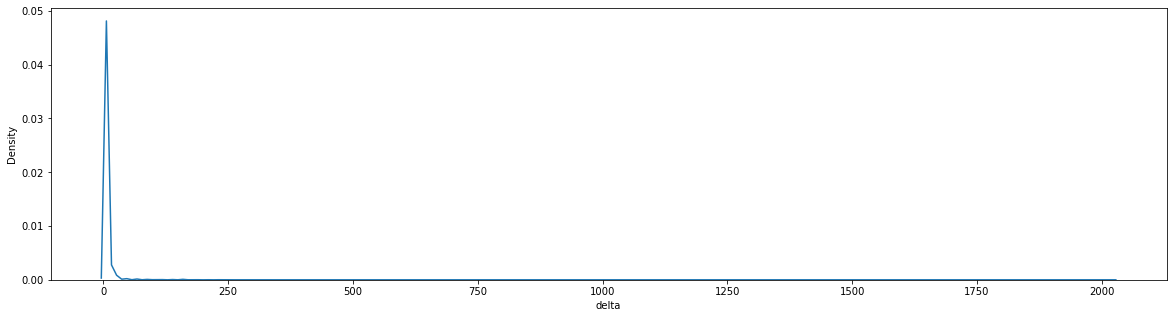

In [65]:
%matplotlib inline
plt.figure(figsize=(20,5))
sns.kdeplot(data=X_test['delta'])